### Libraries

In [1]:
import json
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression



### Models

In [2]:

MODELS = [
    "Alibaba-NLP/gte-large-en-v1.5",
    "intfloat/multilingual-e5-large",
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/all-MiniLM-L6-v2"
]

DATA_PATH = '../data/sentence-embeddings'
RELATIONS_JSON_PATH = '../data/relations.json'

### Obtaining Relation Lookup

In [3]:
with open(RELATIONS_JSON_PATH, 'r') as f:
    relations = json.load(f)['spatial_relations']

In [4]:
def get_relations_lookup(relations):
    relations_lookup = {}
    for category, category_pairs in relations.items():
        for first, second in category_pairs:
            relations_lookup[first] = {'category': category, 'opposite': second, 'position': 0}
            relations_lookup[second] = {'category': category, 'opposite': first, 'position': 1}
    return relations_lookup

relations_lookup = get_relations_lookup(relations)

### Load embeddings for model

In [5]:
def load_embeddings_for_model(model_name, relations_lookup):
    embeddings = []
    labels = []
    raw_data = torch.load(f'{DATA_PATH}/{model_name.replace("/", "_")}.pt', weights_only=False)
    for data_point in raw_data:
        embeddings.append(data_point['embedding'])
        labels.append(data_point['relation'])
    return np.array(embeddings), np.array(labels).reshape(-1, 1)

### A naive test
Here we train probes for each model, using a simple MLP classifier. 

In [6]:
results = {}
models = {}
one_hot_encoder = OneHotEncoder()

for model_name in MODELS:
    print(f"Training probe for {model_name}...")
    X, y = load_embeddings_for_model(model_name, relations_lookup)
    y_encoded = one_hot_encoder.fit_transform(y).todense()
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2) 

    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    # Train probe
    clf = MLPClassifier(activation='identity')
    clf.fit(X_train, y_train)
    models[model_name] = clf

    y_pred = clf.predict(X_test)    
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

Training probe for Alibaba-NLP/gte-large-en-v1.5...


UnpicklingError: invalid load key, 'v'.

### Code for training probe

#### Train logistic regression 

In [13]:
def train_logistic_probe(X, y):
    # LogisticRegression expects 1D labels for multi-class classification.
    # We'll flatten y (assuming it's a column vector of labels).
    y_flat = y.flatten()
    X_train, X_test, y_train, y_test = train_test_split(X, y_flat, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    return train_acc, test_acc

In [14]:
def train_probe(X, y, shuffle_labels=False):
    # Optionally shuffle labels to break any true correspondence
    if shuffle_labels:
        y = np.copy(y)
        y = np.random.permutation(y)
    
    one_hot_encoder = OneHotEncoder()
    # Convert to a NumPy array rather than a np.matrix
    y_encoded = one_hot_encoder.fit_transform(y).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Train a linear classifier (MLP with identity activation acts linearly)
    clf = MLPClassifier(activation='identity', max_iter=500, random_state=42) # the number of layers in mlp is by default 100
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [15]:
# Function for MLP probe with identity activation
def train_mlp_probe(X, y, hidden_layer_sizes=(100,)):
    one_hot_encoder = OneHotEncoder()
    y_encoded = one_hot_encoder.fit_transform(y).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='identity', 
                          max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


### Random labels

We shuffle the training labels (spatial relation categories) among the examples, breaking the true mapping between sentences and relations. We then train a probe on the sentence embeddings with these random labels. Since the labels are random, any structure the probe finds would be spurious (the embedding has no systematic correlation with a random label assignment). 

In [21]:


# Evaluate probes on real labels and on shuffled labels for one model (e.g., Alibaba-NLP/gte-large-en-v1.5)
model_name = "Alibaba-NLP/gte-large-en-v1.5"
X, y = load_embeddings_for_model(model_name, relations_lookup)

# Accuracy with true labels
accuracy_true = train_probe(X, y, shuffle_labels=False)
print(f"Accuracy with true labels for {model_name}: {accuracy_true:.2f}")

# Accuracy with shuffled labels (random baseline)
accuracy_shuffled = train_probe(X, y, shuffle_labels=True)
print(f"Accuracy with shuffled labels (random baseline) for {model_name}: {accuracy_shuffled:.2f}")

Accuracy with true labels for Alibaba-NLP/gte-large-en-v1.5: 0.99
Accuracy with shuffled labels (random baseline) for Alibaba-NLP/gte-large-en-v1.5: 0.00


### Random embedding: 
Here we keep the true labels unaltered but replace each sentence’s embedding with a random vector. This tests whether the original task can be solved without the actual embedding information – essentially measuring the task’s baseline difficulty and checking for any dataset biases. 

In [22]:

# Choose one model for demonstration (e.g., Alibaba-NLP/gte-large-en-v1.5)
model_name = "Alibaba-NLP/gte-large-en-v1.5"

# Load real embeddings and labels
X, y = load_embeddings_for_model(model_name, relations_lookup)
print("Original embeddings shape:", X.shape)

# Generate random embeddings with the same shape as X
np.random.seed(42)  # for reproducibility
X_random = np.random.normal(loc=0.0, scale=1.0, size=X.shape)
print("Random embeddings shape:", X_random.shape)

# Evaluate the probe on random embeddings (with true labels)
accuracy_random = train_probe(X_random, y, shuffle_labels=False)
print(f"Accuracy with random embeddings for {model_name}: {accuracy_random:.2f}")

accuracy_not_random = train_probe(X,y, shuffle_labels=False)
print(f"Accuracy with embeddings for {model_name}: {accuracy_not_random:.2f}")

Original embeddings shape: (142100, 1024)
Random embeddings shape: (142100, 1024)
Accuracy with random embeddings for Alibaba-NLP/gte-large-en-v1.5: 0.00
Accuracy with embeddings for Alibaba-NLP/gte-large-en-v1.5: 0.99


#### Varying MLP size

Is our probe too expressive? 

Embeddings shape: (142100, 1024)
Hidden layer size 1: Test Accuracy = 0.002


/Users/miltonlin/Documents/GitHub/spatial_geometry/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden layer size 6: Test Accuracy = 0.833
Hidden layer size 11: Test Accuracy = 0.978
Hidden layer size 16: Test Accuracy = 0.991
Hidden layer size 21: Test Accuracy = 0.984
Hidden layer size 26: Test Accuracy = 0.993
Hidden layer size 31: Test Accuracy = 0.995
Hidden layer size 36: Test Accuracy = 0.996
Hidden layer size 41: Test Accuracy = 0.993
Hidden layer size 46: Test Accuracy = 0.995
Hidden layer size 51: Test Accuracy = 0.995
Hidden layer size 56: Test Accuracy = 0.995
Hidden layer size 61: Test Accuracy = 0.993
Hidden layer size 66: Test Accuracy = 0.996
Hidden layer size 71: Test Accuracy = 0.994
Hidden layer size 76: Test Accuracy = 0.994
Hidden layer size 81: Test Accuracy = 0.995
Hidden layer size 86: Test Accuracy = 0.994
Hidden layer size 91: Test Accuracy = 0.993
Hidden layer size 96: Test Accuracy = 0.993

Summary of Probe Accuracies:
    Hidden_Size  Test_Accuracy
0             1       0.001970
1             6       0.832829
2            11       0.978395
3          

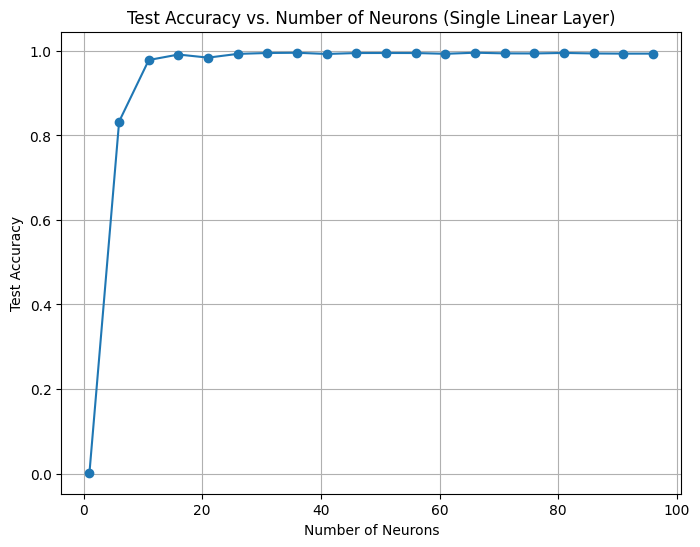

In [16]:

# Load embeddings and labels for our selected model
model_name = MODELS[0]
X, y = load_embeddings_for_model(model_name, relations_lookup)
print("Embeddings shape:", X.shape)

# Experiment: Vary number of neurons in a single hidden layer from 1 to 100 in steps of 5.
hidden_sizes = list(range(1, 101, 5))
results = []

for size in hidden_sizes:
    # Here hidden_layer_sizes=(size,) means one layer with 'size' neurons.
    acc = train_mlp_probe(X, y, hidden_layer_sizes=(size,))
    results.append({"Hidden_Size": size, "Test_Accuracy": acc})
    print(f"Hidden layer size {size}: Test Accuracy = {acc:.3f}")

# Convert results to a DataFrame and plot
results_df = pd.DataFrame(results)
print("\nSummary of Probe Accuracies:")
print(results_df)

plt.figure(figsize=(8, 6))
plt.plot(results_df["Hidden_Size"], results_df["Test_Accuracy"], marker='o', linestyle='-')
plt.title("Test Accuracy vs. Number of Neurons (Single Linear Layer)")
plt.xlabel("Number of Neurons")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

Now we do it for model of smaller sizes

Embeddings shape: (142100, 1024)
Hidden layer size 1: Test Accuracy = 0.002


/Users/miltonlin/Documents/GitHub/spatial_geometry/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden layer size 2: Test Accuracy = 0.053
Hidden layer size 3: Test Accuracy = 0.202


/Users/miltonlin/Documents/GitHub/spatial_geometry/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden layer size 4: Test Accuracy = 0.450
Hidden layer size 5: Test Accuracy = 0.708


/Users/miltonlin/Documents/GitHub/spatial_geometry/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden layer size 6: Test Accuracy = 0.833
Hidden layer size 7: Test Accuracy = 0.908
Hidden layer size 8: Test Accuracy = 0.952
Hidden layer size 9: Test Accuracy = 0.965
Hidden layer size 10: Test Accuracy = 0.975
Hidden layer size 11: Test Accuracy = 0.978
Hidden layer size 12: Test Accuracy = 0.981
Hidden layer size 13: Test Accuracy = 0.985
Hidden layer size 14: Test Accuracy = 0.987
Hidden layer size 15: Test Accuracy = 0.991
Hidden layer size 16: Test Accuracy = 0.991
Hidden layer size 17: Test Accuracy = 0.988
Hidden layer size 18: Test Accuracy = 0.993
Hidden layer size 19: Test Accuracy = 0.993

Summary of Probe Accuracies:
    Hidden_Size  Test_Accuracy
0             1       0.001970
1             2       0.052604
2             3       0.202393
3             4       0.449789
4             5       0.708128
5             6       0.832829
6             7       0.908128
7             8       0.951795
8             9       0.965165
9            10       0.975405
10           11  

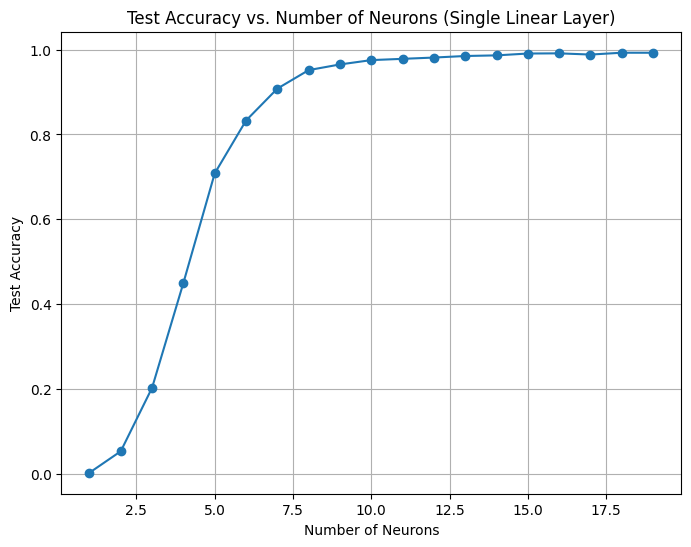

In [17]:

# Load embeddings and labels for our selected model
model_name = MODELS[0]
X, y = load_embeddings_for_model(model_name, relations_lookup)
print("Embeddings shape:", X.shape)

# Experiment: Vary number of neurons in a single hidden layer from 1 to 100 in steps of 5.
hidden_sizes = list(range(5, 20, 1))
results = []

for size in hidden_sizes:
    # Here hidden_layer_sizes=(size,) means one layer with 'size' neurons.
    acc = train_mlp_probe(X, y, hidden_layer_sizes=(size,))
    results.append({"Hidden_Size": size, "Test_Accuracy": acc})
    print(f"Hidden layer size {size}: Test Accuracy = {acc:.3f}")

# Convert results to a DataFrame and plot
results_df = pd.DataFrame(results)
print("\nSummary of Probe Accuracies:")
print(results_df)

plt.figure(figsize=(8, 6))
plt.plot(results_df["Hidden_Size"], results_df["Test_Accuracy"], marker='o', linestyle='-')
plt.title("Test Accuracy vs. Number of Neurons (Single Linear Layer)")
plt.xlabel("Number of Neurons")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

### Number of labels

In [23]:
from datasets import load_dataset
from collections import Counter

# Load the dataset (train split)
dataset = load_dataset("viknat/spatial-geometry", split="train")

# Extract all relation labels
labels = [entry["relation"] for entry in dataset]

# Count unique labels and their frequency
label_counts = Counter(labels)

print(f"Number of unique relation labels: {len(label_counts)}")
print("Label frequencies:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")


/Users/miltonlin/Documents/GitHub/spatial_geometry/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of unique relation labels: 58
Label frequencies:
  above: 2450
  over: 2450
  on top of: 2450
  higher than: 2450
  elevated above: 2450
  to the left of: 2450
  in front of: 2450
  ahead of: 2450
  before: 2450
  inside: 2450
  within: 2450
  enclosed in: 2450
  close to: 2450
  near: 2450
  next to: 2450
  adjacent to: 2450
  beside: 2450
  on: 2450
  attached to: 2450
  stuck to: 2450
  connected to: 2450
  facing: 2450
  pointing toward: 2450
  oriented toward: 2450
  diagonally above-left: 2450
  diagonally above-right: 2450
  perpendicular to: 2450
  equidistant from: 2450
  at 45 degrees to: 2450
  below: 2450
  under: 2450
  beneath: 2450
  lower than: 2450
  dropped below: 2450
  to the right of: 2450
  behind: 2450
  at the back of: 2450
  after: 2450
  outside: 2450
  beyond: 2450
  excluded from: 2450
  far from: 2450
  distant from: 2450
  away from: 2450
  opposite from: 2450
  apart from: 2450
  off: 2450
  detached from: 2450
  separated from: 2450
  disconnected

### Control tasks
Control tasks are designed so that the output (label) is determined solely by a surface-level property (e.g., the subject of the sentence) and is random with respect to the true spatial relation. We generate control label: For each example, use the subject as the key and assign a random relation label (from the full set of relation labels). This yields control labels that do not depend on the actual spatial relation but only on the subject identity.

Using the same procedure as your original probe training (splitting data, one-hot encoding, training an MLP with identity activation), train a classifier to predict the control labels from the embeddings.


In [19]:
# For each unique subject, assign a random label from the set of all relation labels.
def generate_control_labels(data_path, model_name, relations_lookup):
    # Load the data (we assume the same format used for embeddings)
    raw_data = torch.load(f'{DATA_PATH}/{model_name.replace("/", "_")}.pt', weights_only=False)
    control_labels = []
    # Extract the set of all possible relation labels from relations_lookup keys
    possible_labels = list(relations_lookup.keys())
    subject_to_control = {}
    
    for data_point in raw_data:
        subject = data_point['subject']
        # If subject not seen before, assign it a random label
        if subject not in subject_to_control:
            subject_to_control[subject] = np.random.choice(possible_labels)
        control_labels.append(subject_to_control[subject])
    return np.array(control_labels).reshape(-1, 1)

# Function for training a probe (using an MLP with identity activation)
def train_probe(X, y):
    one_hot_encoder = OneHotEncoder()
    y_encoded = one_hot_encoder.fit_transform(y).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    #our classifier has only 1 layer and 15 neurons
    clf = MLPClassifier(hidden_layer_sizes=(15,), activation='identity', max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Choose one model for demonstration
model_name = "Alibaba-NLP/gte-large-en-v1.5"
X, y_true = load_embeddings_for_model(model_name, relations_lookup)
print("Embeddings shape:", X.shape)

# Train a probe on the true linguistic task
accuracy_true = train_probe(X, y_true)
print(f"Accuracy on true labels: {accuracy_true:.2f}")

# Generate control labels based on subject (i.e., a random mapping per subject)
control_labels = generate_control_labels(DATA_PATH, model_name, relations_lookup)

# Train a probe on the control task
accuracy_control = train_probe(X, control_labels)
print(f"Accuracy on control (random subject-based) labels: {accuracy_control:.2f}")

# Optionally, compute selectivity as difference in accuracy
selectivity = accuracy_true - accuracy_control
print(f"Selectivity (true - control): {selectivity:.2f}")

Embeddings shape: (142100, 1024)
Accuracy on true labels: 0.99
Accuracy on control (random subject-based) labels: 0.98
Selectivity (true - control): 0.01


 probe achieves 99% accuracy on true labels and 98% on control labels. The minimal difference (selectivity of 1%) indicates that the probe is likely exploiting superficial (e.g., word identity) cues that are present in both label assignments.